In [36]:
import pandas as pd
import numpy as np
import datetime
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
data0 = pd.read_csv("data/1019_SP.csv").dropna()
data1 = pd.read_csv("data/1019_CL.csv").dropna()
data2 = pd.read_csv("data/1019_OVX.csv").dropna()
data3 = pd.read_csv("data/1019_GC.csv").dropna()
data4 = pd.read_csv("data/1019_GVZ.csv").dropna()
Date = data0.get("Date")
Date = pd.to_datetime(Date)
Close = data0.get("Close")
Close_cl = data1.get("Close")
Close_ovx = data2.get("Close")
Close_gc = data3.get("Close")
Close_gvz = data4.get("Close")
dict = {"Date": Date,
        "close": Close, 
        "close_cl": Close_cl, 
        "close_ovx": Close_ovx,
        "close_gc": Close_gc, 
        "close_gvz": Close_gvz,
       }
df = pd.DataFrame(dict)
df.set_index('Date', inplace=True)
df = df.dropna()
print("總共:%d個交易時間點" % (len(Date)))
print("去除空白值後剩下:%d個交易時間點" % (len(df)))
df.tail(10)

總共:2493個交易時間點
去除空白值後剩下:2493個交易時間點


,close,close_cl,close_ovx,close_gc,close_gvz
Date,,,,,
2019-12-13,3168.800049,60.070000,26.760000,1475.599976,10.39
2019-12-16,3191.449951,60.209999,26.510000,1475.000000,10.39
2019-12-17,3192.520020,60.939999,26.330000,1474.599976,10.03
2019-12-18,3191.139893,60.930000,26.770000,1472.599976,10.04
2019-12-19,3205.370117,61.220001,24.799999,1478.199951,10.39
2019-12-20,3221.219971,60.439999,25.540001,1474.699951,9.69
2019-12-23,3224.010010,60.520000,25.110001,1482.500000,10.56
2019-12-26,3239.909912,61.680000,24.080000,1509.300049,13.33
2019-12-27,3240.020020,61.720001,25.160000,1513.800049,12.32


In [ ]:
dataset = pd.DataFrame({
    'Close':df['close'],
    'Close_CL':df['close_cl'],
    'Close_OVX':df['close_ovx'],
    'Close_GC':df['close_gc'],
    'Close_GVZ':df['close_gvz'],
    'return': df['close'],
})

feature_names = list(dataset.columns[:-1])

In [38]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)

before dropping NaN (2493, 6)
after dropping NaN (2493, 6)


In [39]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
#dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,Close,Close_CL,Close_OVX,Close_GC,Close_GVZ,return
count,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000
mean,0.422965,0.527754,0.290049,0.353032,0.261824,0.422965
std,0.265162,0.249914,0.156572,0.213666,0.156178,0.265162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.161118,0.298108,0.187839,0.207304,0.142903,0.161118
50%,0.434046,0.514706,0.269117,0.289533,0.246540,0.434046
75%,0.636121,0.767556,0.375989,0.457453,0.347602,0.636121
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
from keras.utils import np_utils
#每張圖包含幾天的資料
time_period = 20
#預設幾日後的漲跌
day = 10

cnn_x = []
cnn_y = []
indexs = []
dataset_scaled_x= dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-time_period-1-day)):
    cnn_x.append(dataset_scaled_x.iloc[i:i+time_period].values)
    r = dataset_scaled['return'].iloc[i+time_period-1+day]/dataset_scaled['return'].iloc[i+time_period-1]
    if r > 1:
        r = 0
    else:
        r = 1
    rr = np_utils.to_categorical(r, num_classes=2)
    cnn_y.append(rr)
    indexs.append(dataset_scaled.index[i+time_period-1])
    
cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


In [ ]:
#2010~2018年為訓練和測試，2019年則為驗證
import datetime
cnn_x_t = cnn_x[indexes < datetime.datetime(2019,1,1)]
cnn_y_t = cnn_y[indexes < datetime.datetime(2019,1,1)]
cnn_x_validation = cnn_x[indexes > datetime.datetime(2019,1,1)]
cnn_y_validation = cnn_y[indexes > datetime.datetime(2019,1,1)]

In [ ]:
from sklearn.model_selection import train_test_split
cnn_x_train, cnn_x_test, cnn_y_train, cnn_y_test = train_test_split(cnn_x_t, cnn_y_t, test_size=0.2)

In [ ]:
cnn_x_train = np.stack((cnn_x_train,)*3,axis=-1)
cnn_x_test = np.stack((cnn_x_test,)*3,axis=-1)
cnn_x_validation = np.stack((cnn_x_validation,)*3,axis=-1)

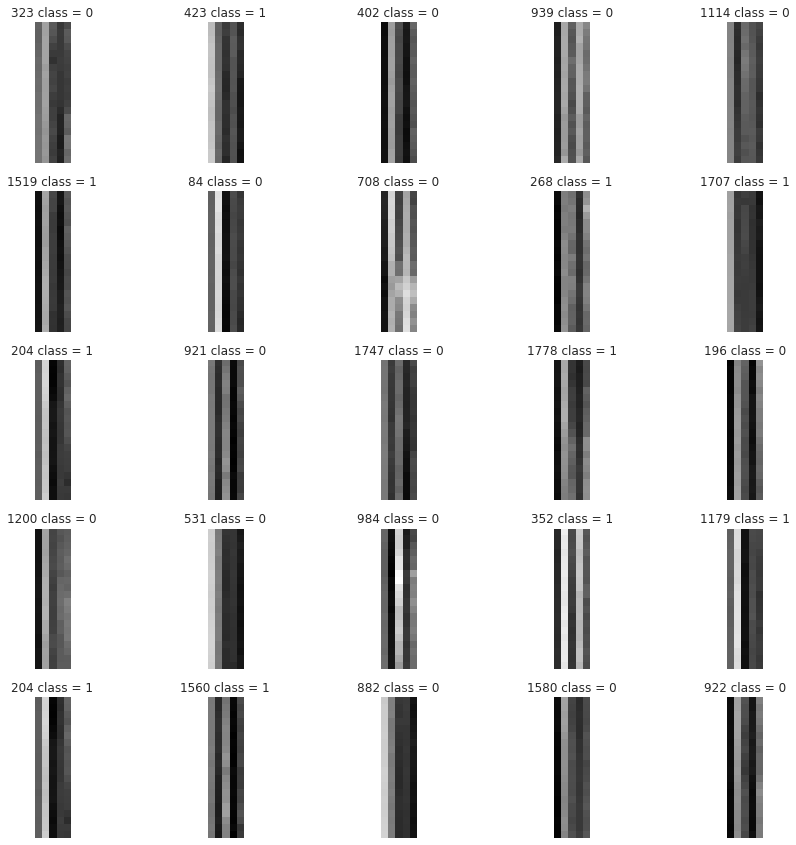

In [44]:
fig = plt.figure(figsize = (15,15))
columns = rows = 5
for i in range(1,columns*rows+1):
  index = np.random.randint(len(cnn_x_train))
  img = cnn_x_train[index]
  fig.add_subplot(rows,columns,i)
  plt.axis("off")
  plt.title(str(index)+' class = '+str(np.argmax(cnn_y_train[index])))
  plt.subplots_adjust(wspace=0.2,hspace=0.2)
  plt.imshow(img)
plt.show()

In [45]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal

input_shape = cnn_x_train[0].shape

model = Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu',
                        padding="same",
                        input_shape=input_shape))
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu',
                        padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer="Adam", metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 5, 32)         896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 5, 64)         18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 2, 64)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 2, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [46]:
from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=100,
                    epochs=250,
                    verbose=1,
                    validation_data=(cnn_x_test,cnn_y_test),
                    callbacks=[earlystop],
                    )

Epoch 1/250
18/18 [==============================] - 0s 11ms/step - loss: 0.6718 - accuracy: 0.6163 - val_loss: 0.6466 - val_accuracy: 0.6502
Epoch 2/250
18/18 [==============================] - 0s 6ms/step - loss: 0.6641 - accuracy: 0.6258 - val_loss: 0.6470 - val_accuracy: 0.6502
Epoch 3/250
18/18 [==============================] - 0s 6ms/step - loss: 0.6596 - accuracy: 0.6258 - val_loss: 0.6521 - val_accuracy: 0.6502
Epoch 4/250
18/18 [==============================] - 0s 6ms/step - loss: 0.6578 - accuracy: 0.6258 - val_loss: 0.6486 - val_accuracy: 0.6502
Epoch 5/250
18/18 [==============================] - 0s 6ms/step - loss: 0.6566 - accuracy: 0.6258 - val_loss: 0.6456 - val_accuracy: 0.6502
Epoch 6/250
18/18 [==============================] - 0s 6ms/step - loss: 0.6537 - accuracy: 0.6253 - val_loss: 0.6375 - val_accuracy: 0.6502
Epoch 7/250
18/18 [==============================] - 0s 5ms/step - loss: 0.6518 - accuracy: 0.6264 - val_loss: 0.6437 - val_accuracy: 0.6570
Epoch 8/250


In [47]:
o_loss,o_accuracy = model.evaluate(cnn_x_train,cnn_y_train)
print("對訓練資料的：\nLoss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
n_loss,n_accuracy = model.evaluate(cnn_x_test,cnn_y_test)
print("對測試資料的：\nLoss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))

56/56 [==============================] - 0s 2ms/step - loss: 0.3163 - accuracy: 0.8635
對訓練資料的：
Loss: 0.32, Accuracy: 0.86
14/14 [==============================] - 0s 2ms/step - loss: 0.4720 - accuracy: 0.8408
對測試資料的：
Loss: 0.47, Accuracy: 0.84


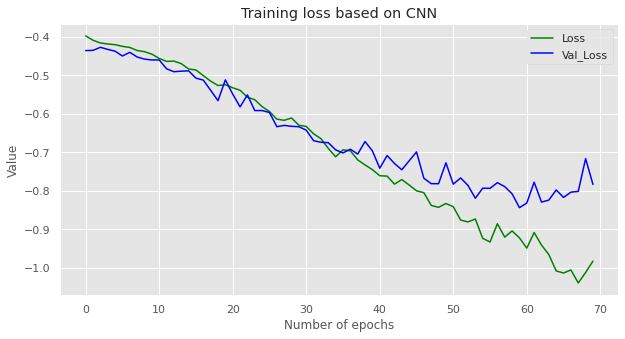

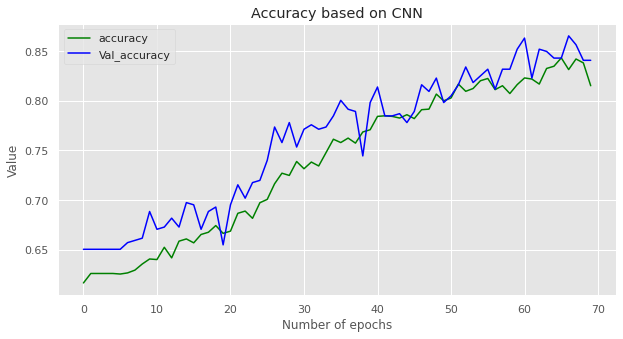

In [48]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.log(history.history['loss']), color = 'green', label='Loss')
plt.plot(np.log(history.history['val_loss']), color = 'blue', label='Val_Loss')
plt.legend()
plt.title('Training loss based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], color = 'green', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='Val_accuracy')
plt.legend()
plt.title('Accuracy based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()

In [ ]:
pre = model.predict_classes(cnn_x_test)
pre = pd.Series(pre)

TP: 262.00, FN: 28.00, FP: 43.00, TN: 113.00
對訓練集資料的：Loss: 0.32, Accuracy: 0.86
對測試集資料的：Loss: 0.47, Accuracy: 0.84

測試資料總共：446.00 筆, 其中漲的筆數為: 290.00, 全部猜漲猜對的機率是: 0.65
該測試集資料的：
Accuracy: 0.84, Precision: 0.86, Recall: 0.90
F1 score: 0.88


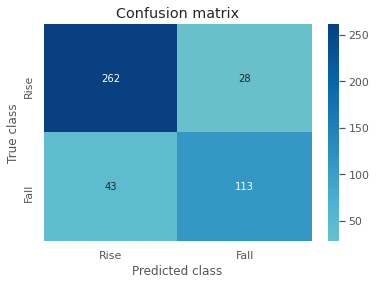

In [50]:
from sklearn.metrics import confusion_matrix

#將onehot編碼轉回數組cnn_x_validation
cnn_y_test = np.argmax(cnn_y_test, axis=1)
xcnn_y_test = pd.Series(cnn_y_test)

LABELS = ["Rise","Fall"]
conf_matrix = confusion_matrix(xcnn_y_test, pre)

t_size = len(cnn_y_test)
t_size1 = (cnn_y_test<1).sum()
t_guess = ((cnn_y_test<1).sum())/(len(cnn_y_test))

TP = conf_matrix[0][0]
FN = conf_matrix[0][1]
FP = conf_matrix[1][0]
TN = conf_matrix[1][1]
accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))
print("TP: %.2f, FN: %.2f, FP: %.2f, TN: %.2f" % (TP,FN,FP,TN))
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆, 其中漲的筆數為: %.2f, 全部猜漲猜對的機率是: %.2f" % (t_size, t_size1, t_guess))
print("該測試集資料的：\nAccuracy: %.2f, Precision: %.2f, Recall: %.2f\nF1 score: %.2f" % (accuracy, precision,recall,F1))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

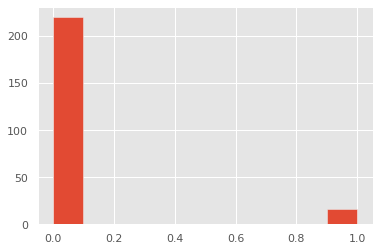

In [51]:
pre = model.predict_classes(cnn_x_validation)
pre = pd.Series(pre)
pre.hist()

TP: 156.00, FN: 16.00, FP: 64.00, TN: 0.00
對訓練集資料的：Loss: 0.32, Accuracy: 0.86
對測試集資料的：Loss: 0.47, Accuracy: 0.84

測試資料總共：236.00 筆, 其中漲的筆數為: 172.00, 全部猜漲猜對的機率是: 0.73
該測試集資料的：
Accuracy: 0.66, Precision: 0.71, Recall: 0.91
F1 score: 0.80


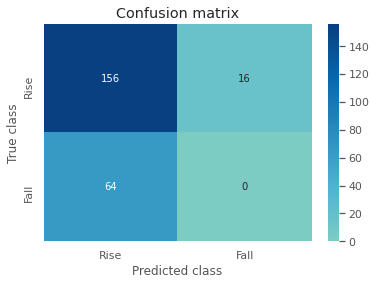

In [52]:
from sklearn.metrics import confusion_matrix

#將onehot編碼轉回數組cnn_x_validation
cnn_y_validation = np.argmax(cnn_y_validation, axis=1)
xcnn_y_validation = pd.Series(cnn_y_validation)

LABELS = ["Rise","Fall"]
conf_matrix = confusion_matrix(xcnn_y_validation, pre)

t_size = len(cnn_y_validation)
t_size1 = (cnn_y_validation<1).sum()
t_guess = ((cnn_y_validation<1).sum())/(len(cnn_y_validation))

TP = conf_matrix[0][0]
FN = conf_matrix[0][1]
FP = conf_matrix[1][0]
TN = conf_matrix[1][1]
accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))
print("TP: %.2f, FN: %.2f, FP: %.2f, TN: %.2f" % (TP,FN,FP,TN))
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆, 其中漲的筆數為: %.2f, 全部猜漲猜對的機率是: %.2f" % (t_size, t_size1, t_guess))
print("該測試集資料的：\nAccuracy: %.2f, Precision: %.2f, Recall: %.2f\nF1 score: %.2f" % (accuracy, precision,recall,F1))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()